# Check GPU is online

In [69]:
import tensorflow as tf
tf.Session(config=tf.ConfigProto(log_device_placement=True))
tf.test.gpu_device_name()

'/device:GPU:0'

## Data understanding

In [45]:
import glob
import numpy as np
import os
import SimpleITK as sitk
from scipy.stats import itemfreq

In [11]:
rootPath = "Z:/VoorJing/training"
testPath = "Z:/VoorJing/testing"

In [12]:
def loadData( rootPath, padding= 25 ):
    
    imageFilenames = glob.glob(os.path.join(rootPath, "*", "mri", "miT1W_3D_TFE.nii"))
    if len(imageFilenames) == 0: # Load a single subject
        imageFilenames = glob.glob(os.path.join(rootPath, "mri", "miT1W_3D_TFE.nii"))        
    
    flairFilenames = [x.replace('mri\\miT1W_3D_TFE', 'features\\T2_FLAIR') for x in imageFilenames]
    labelFilenames = [x.replace('mri\\miT1W_3D_TFE', 'features\\labels') for x in imageFilenames]
    
    images = None # shape: (numImages, z, y, x, channels=1)
    labels = None
    masks  = None
    
    for imageFilename, flairFilename, labelFilename in zip(imageFilenames, flairFilenames, labelFilenames):
        # Load the images
        imageImage = sitk.ReadImage(imageFilename)
        flairImage = sitk.ReadImage(flairFilename)
        labelImage = sitk.ReadImage(labelFilename)
        # Convert to arrays
        imageArray = np.pad(sitk.GetArrayFromImage(imageImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        flairArray = np.pad(sitk.GetArrayFromImage(flairImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
        maskArray = labelArray > 0
        
        # Add to the images/labels array
        if images is None:
            images = imageArray.reshape([1] + list(imageArray.shape) + [1])
            images = np.concatenate([images, flairArray.reshape([1] + list(flairArray.shape) + [1])], axis=4)
            labels = labelArray.reshape([1] + list(labelArray.shape) + [1])
            masks  = maskArray.reshape([1] + list(maskArray.shape) + [1])
        else:
            tempArray = np.concatenate([imageArray.reshape([1] + list(imageArray.shape) + [1]), flairArray.reshape([1] + list(flairArray.shape) + [1])], axis=4)
            images = np.concatenate([images, tempArray])
            
            labels = np.concatenate([labels, labelArray.reshape([1] + list(labelArray.shape) + [1])])
            masks  = np.concatenate([masks, maskArray.reshape([1] + list(maskArray.shape) + [1])])              
    return images, labels, masks

In [13]:
images,labels, masks = loadData(rootPath, padding=25)
nonZeroIdx = np.nonzero(masks)

In [14]:
print("labels:\n",itemfreq(labels.astype(int)))

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


labels:
 [[       0 53269774]
 [       1  2039968]
 [       2  2720616]
 [       3  2006776]
 [       4   178135]
 [       5    34320]
 [       7   159740]
 [       8       34]
 [      10   142631]
 [      13        6]]


In [15]:
testImages, testLabels, testMasks = loadData(testPath, padding=25)
testNonZeroIdx = np.nonzero(testMasks)

In [16]:
print("testLabels:\n",itemfreq(testLabels.astype(int)))

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


testLabels:
 [[       0 17812550]
 [       1   613180]
 [       2   890849]
 [       3   628786]
 [       4    90766]
 [       5    42917]
 [       7    57516]
 [      10    47436]]


## Balenced sample

In [44]:
import pickle

In [12]:
train_classed =[np.nonzero(labels == x) for x in np.unique(labels)]
test_classed =[np.nonzero(testLabels == x) for x in np.unique(testLabels)]

In [13]:
train_classed[7]

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64),
 array([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 41, 41, 41, 41,
        41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41],
       dtype=int64),
 array([185, 185, 185, 186, 186, 186, 186, 186, 187, 187, 187, 187, 187,
        185, 185, 185, 185, 185, 185, 186, 186, 186, 186, 186, 186, 186,
        187, 187, 187, 187, 187, 187, 188, 188], dtype=int64),
 array([176, 177, 178, 174, 175, 176, 177, 178, 173, 174, 175, 176, 177,
        167, 168, 169, 170, 171, 172, 166, 167, 168, 169, 170, 171, 172,
        165, 166, 167, 170, 171, 172, 165, 166], dtype=int64),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64))

In [14]:
train_classed[9]

(array([12, 12, 12, 12, 12, 12], dtype=int64),
 array([18, 18, 18, 27, 27, 27], dtype=int64),
 array([ 90,  91,  91, 121, 122, 122], dtype=int64),
 array([124, 123, 124, 120, 120, 121], dtype=int64),
 array([0, 0, 0, 0, 0, 0], dtype=int64))

In [15]:
del train_classed[9]
del train_classed[7]

In [16]:
train_classed = np.array(train_classed)
test_classed = np.array(test_classed)

In [17]:
print(train_classed.shape)
print(test_classed.shape)

(8, 5)
(8, 5)


In [18]:
pickle.dump( train_classed,  open( 'train_classed.pickle', 'wb' ) )
pickle.dump( test_classed ,  open( 'test_classed.pickle', 'wb' ) )

## Segmentation

In [19]:
with open("train_classed.pickle", 'rb') as f:
    train_classed = pickle.load(f)
with open("test_classed.pickle", 'rb') as f:
    test_classed = pickle.load(f)

In [43]:
import matplotlib.pyplot as plt 

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K

import datetime
import platform
import pandas as pd
from sklearn.utils import shuffle

In [21]:
batchSize = 70
batchShape = (batchSize, 51, 51, 2)
rs = np.random.RandomState(354351)
num_classes = 14

In [57]:
def batchGeneratorMaskedbalenced(images, labels, nonZeroIdx, data_classed, shape, rs=np.random):    
    while True:
        batchImages = np.zeros(shape, dtype=np.float32)
        batchLabels = np.zeros((shape[0], 1), dtype=np.float32)
        n_label = shape[0]//(len(data_classed)-1)
#         print("shape[0]",shape[0])
#         print("len(data_classed)",len(data_classed))
#         print("n_label",n_label)
        for c in range(1, len(data_classed)):
            sampleIdx = rs.randint(0, len(data_classed[c][0]), n_label)
#             print(c)
#             print(sampleIdx)
#             print(data_classed[c])
#             print(train_classed[9][3])
#             print(train_classed[9][3][sampleIdx[idx]])
#             print("sampleIdx",sampleIdx)
#             print("shape",len(nonZeroIdx[0]))
            for idx in range(len(sampleIdx)):

                zs = data_classed[c][1][sampleIdx[idx]]
                ze = zs + 1

                ys = int(data_classed[c][2][sampleIdx[idx]] - 0.5*(shape[1]-1))
                ye = int(data_classed[c][2][sampleIdx[idx]] + 0.5*(shape[1]-1) + 1)

                xs = int(data_classed[c][3][sampleIdx[idx]] - 0.5*(shape[2]-1))
                xe = int(data_classed[c][3][sampleIdx[idx]] + 0.5*(shape[2]-1) + 1)            
#                 print("sampleIdx",sampleIdx)
#                 print("idx",idx)
#                 print("data_classed[c]",data_classed[c])
#                 print("data_classed[c][0]",data_classed[c][0])
#                 print("data_classed[c][0][sampleIdx[idx]]",data_classed[c][0][sampleIdx[idx]])
#                 print("data_classed[c][0][sampleIdx[idx]]",data_classed[c][0][sampleIdx[idx]])
#                 print("images.shape",images.shape)
                try:
#                     print((c-1)*n_label+idx)
                    batchImages[(c-1)*n_label+idx,:,:,:] = images[data_classed[c][0][sampleIdx[idx]], zs:ze, ys:ye, xs:xe]
                    batchLabels[(c-1)*n_label+idx] = labels[data_classed[c][0][sampleIdx[idx]], data_classed[c][1][sampleIdx[idx]], data_classed[c][2][sampleIdx[idx]], data_classed[c][3][sampleIdx[idx]] ]
                except:
                    print(xs,xe,ys,ye,zs,ze)    
                    raise
#             print("lll")
#         print(batchImages.shape)
#         print(batchImages[54])
        batchImages, batchLabels = shuffle( batchImages, batchLabels)                            
        yield batchImages, batchLabels

In [24]:
batchGeneratorMaskedbalenced(images, labels, nonZeroIdx, train_classed, batchShape, rs)

<generator object batchGeneratorMaskedbalenced at 0x00000255E78A1DB0>

In [59]:
#%%
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=batchShape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              #optimizer=keras.optimizers.Adadelta(),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

#%%

#iterator = batchGenerator(images, labels, batchShape, rs)
iterator = batchGeneratorMaskedbalenced(images, labels, nonZeroIdx, train_classed, batchShape, rs)
tbCallBack = keras.callbacks.TensorBoard(log_dir='D:/tensorflow_log/train', 
                                         histogram_freq=0, write_graph=True, write_images=True)

df = None
max_iters = 100000
for idx, (x_train, y_train) in enumerate(iterator):
    y_train = keras.utils.to_categorical(y_train, num_classes)
    
    if idx % 5000 == 0:
        x_test, y_test = next(batchGeneratorMaskedbalenced(testImages, testLabels, testNonZeroIdx, test_classed, batchShape))
        y_test = keras.utils.to_categorical(y_test, num_classes)        
        
        score = model.fit(x_train, y_train,
                  batch_size=batchSize,
                  verbose=0,
                  validation_data=(x_test, y_test),
                  )
        
        score.history['idx']= idx
        
        if df is None:
            df = pd.DataFrame.from_dict(score.history)
        else:
            df = df.append(pd.DataFrame.from_dict(score.history))
            
        # Store the params
        model.save('C:/Users/Jing/Documents/umcu/src/model/cnn_brain_segmentation_model_balenced_' 
                   + datetime.datetime.today().strftime('%Y%m%d_%H%M%S') + '_idx.h5')
                
        plt.plot(df.idx, df.acc, df.idx, df.val_acc, df.idx, df.acc.rolling(10).mean(), df.idx, df.val_acc.rolling(10).mean())
        try:
            plt.savefig('D:/tensorflow_log/train.png', dpi=200)
            plt.close()
        except:
            pass
    else:
        model.fit(x_train, y_train,
                  batch_size=batchSize,
                  verbose=0,
                  )
    
    if idx == max_iters:
        break

#11.42 gestart
model.save('C:/Users/Jing/Documents/umcu/src/model/cnn_brain_segmentation_model_balenced_' 
           + datetime.datetime.today().strftime('%Y%m%d_%H%M%S') + '.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 49, 49, 32)        608       
_________________________________________________________________
batch_normalization_105 (Bat (None, 49, 49, 32)        128       
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
batch_normalization_106 (Bat (None, 47, 47, 32)        128       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
batch_normalization_107 (Bat (None, 21, 21, 32)        128       
__________

## apply model

In [22]:
from keras.models import Model, Sequential

In [141]:
def batchTestGeneratorMasked(images, labels, nonZeroIdx, shape):  
    idx = 0
    while idx < len(nonZeroIdx[0]):        
        batchImages = np.zeros(shape, dtype=np.float32)
        batchLabels = np.zeros((shape[0], 1), dtype=np.float32)
        for i in range(shape[0]):              
            zs = nonZeroIdx[1][idx]
            ze = zs + 1
            
            ys = int(nonZeroIdx[2][idx] - 0.5*(shape[1]-1))
            ye = int(nonZeroIdx[2][idx] + 0.5*(shape[1]-1) + 1)
            
            xs = int(nonZeroIdx[3][idx] - 0.5*(shape[2]-1))
            xe = int(nonZeroIdx[3][idx] + 0.5*(shape[2]-1) + 1)            
            
            batchImages[i,:,:,:] = images[nonZeroIdx[0][idx], zs:ze, ys:ye, xs:xe]
            
            batchLabels[i] = labels[nonZeroIdx[0][idx], nonZeroIdx[1][idx], nonZeroIdx[2][idx], nonZeroIdx[3][idx] ]
            
            idx += 1      
            
            # Check if we go beyond the image(s)
            if idx >= len(nonZeroIdx[0]):
                break
        
        # In case we have reached the last batch, crop to i+1                      
        yield batchImages[:i+1], batchLabels[:i+1]
    
    return

In [64]:
batchSize = 150
batchShape = (batchSize, 51, 51, 2)
# testPath = "Z:/VoorJing/extra-test"
   
testImages, testLabels, testMasks = loadData(testPath)
testNonZeroIdx = np.nonzero(testMasks)

model = keras.models.load_model("C:/Users/Jing/Documents/umcu/src/model/cnn_brain_segmentation_model_balenced_20181019_174700.h5")
novelty_model = Model(inputs=model.input, outputs=model.get_layer("dense_41").output)


iterator = batchTestGeneratorMasked(testImages, testLabels, testNonZeroIdx, batchShape)

i = 0
r = 0
result = None
novelty = None

for predictImages, predictLabels in iterator:
    resultModel = model.predict_on_batch(predictImages)
    resultNovelty = novelty_model.predict_on_batch(predictImages)
    
    if result is None:
        result = resultModel
        novelty = resultNovelty
    else:
        result = np.concatenate([result, resultModel])
        novelty = np.concatenate([novelty, resultNovelty])
        r+=1
        if r%2000==0:
            print (r)

2000
4000
6000
8000
10000
12000
14000


In [69]:
pickle.dump( result,  open( 'model_20181022_balanced_100000.pickle', 'wb' ) )
pickle.dump( novelty ,  open( 'novelty_20181022_balanced_100000.pickle', 'wb' ) )

In [39]:
def myshow(img, title=None, margin=0.05, dpi=100):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (4 + margin) * ysize / dpi, (4 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
   
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

(48, 290, 290)
(48, 290, 290)
(48, 290, 290)
(48, 290, 290)
(48, 290, 290)


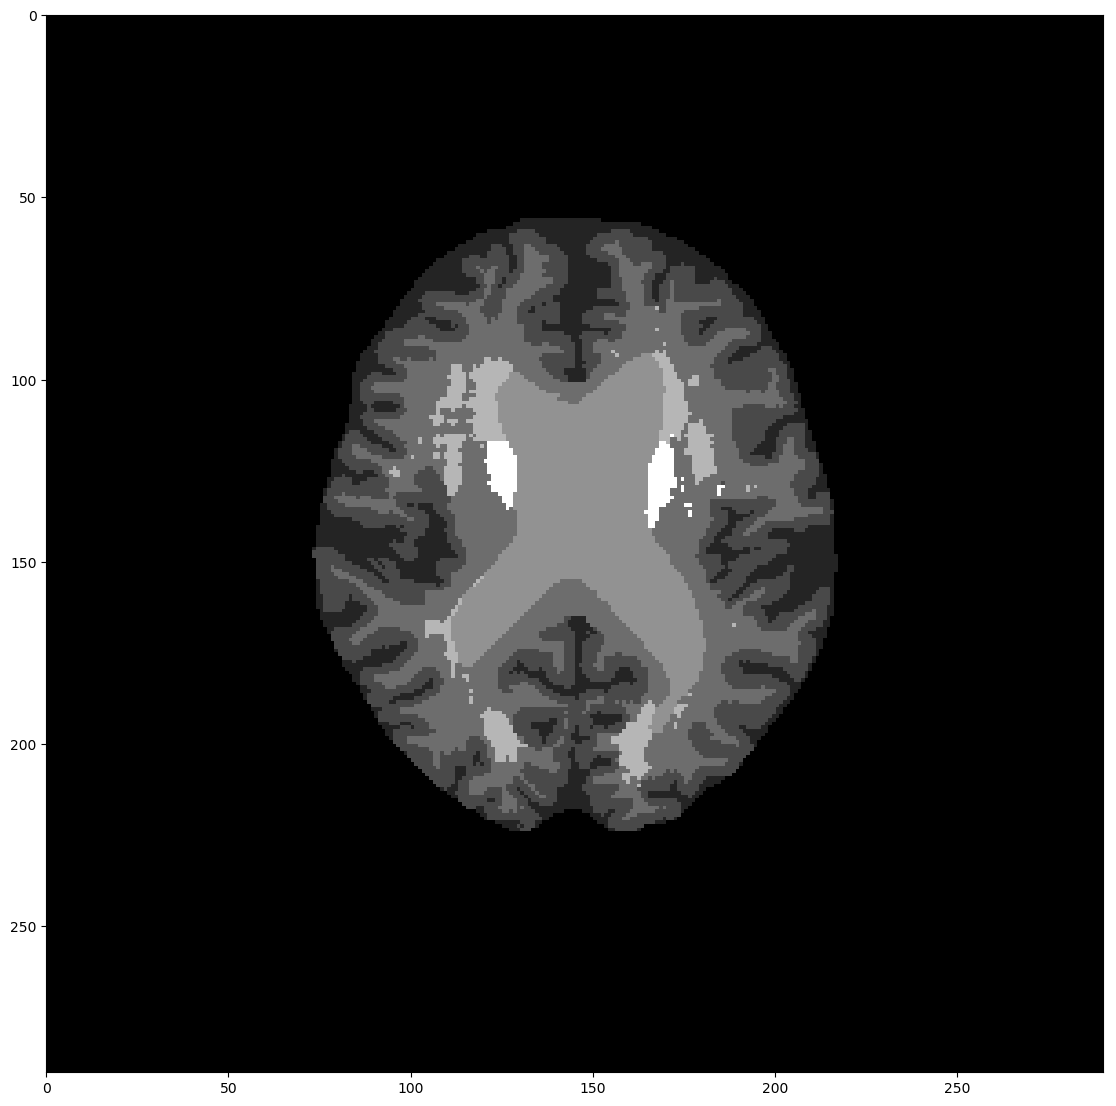

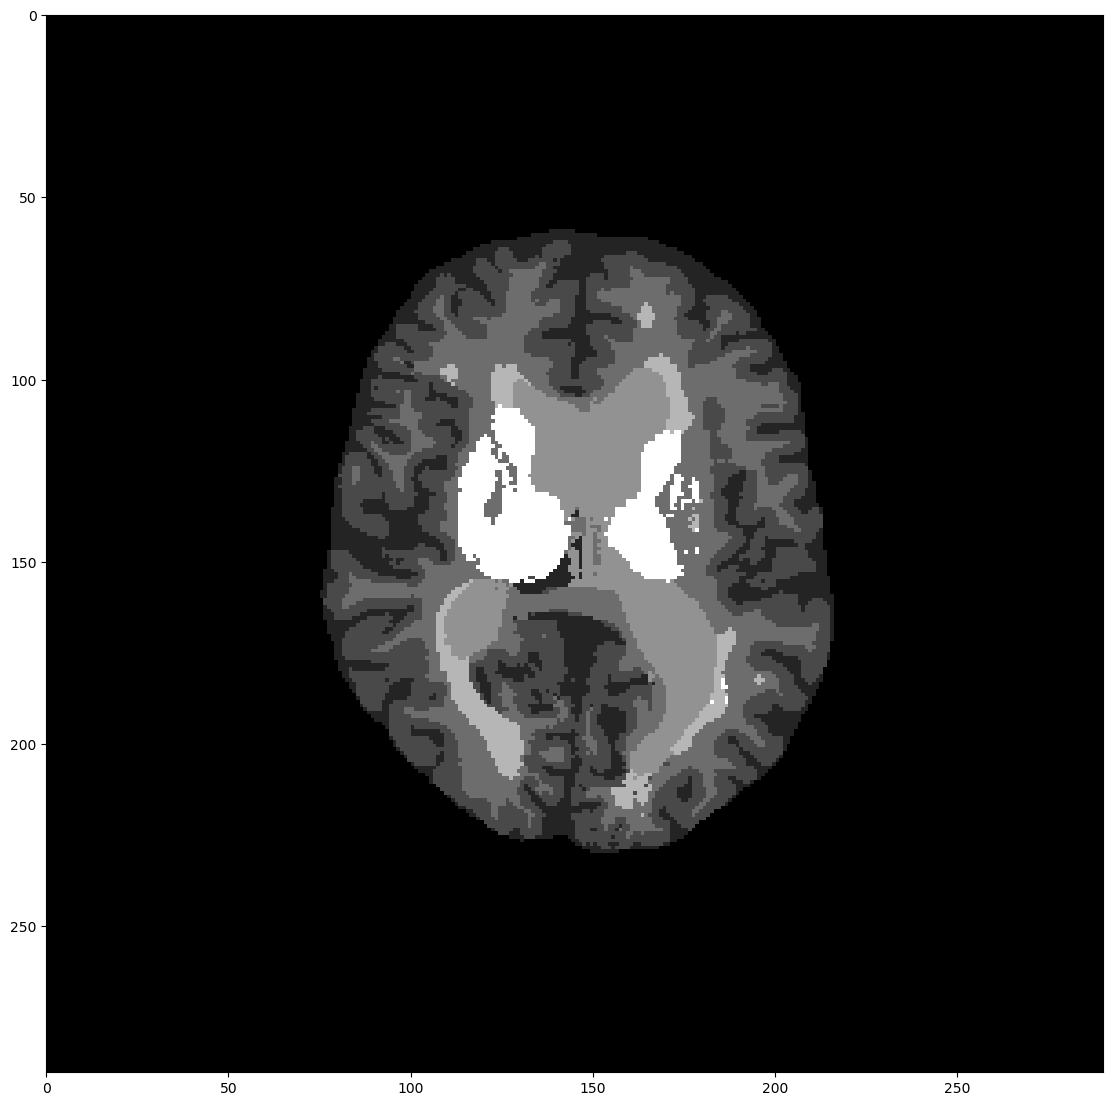

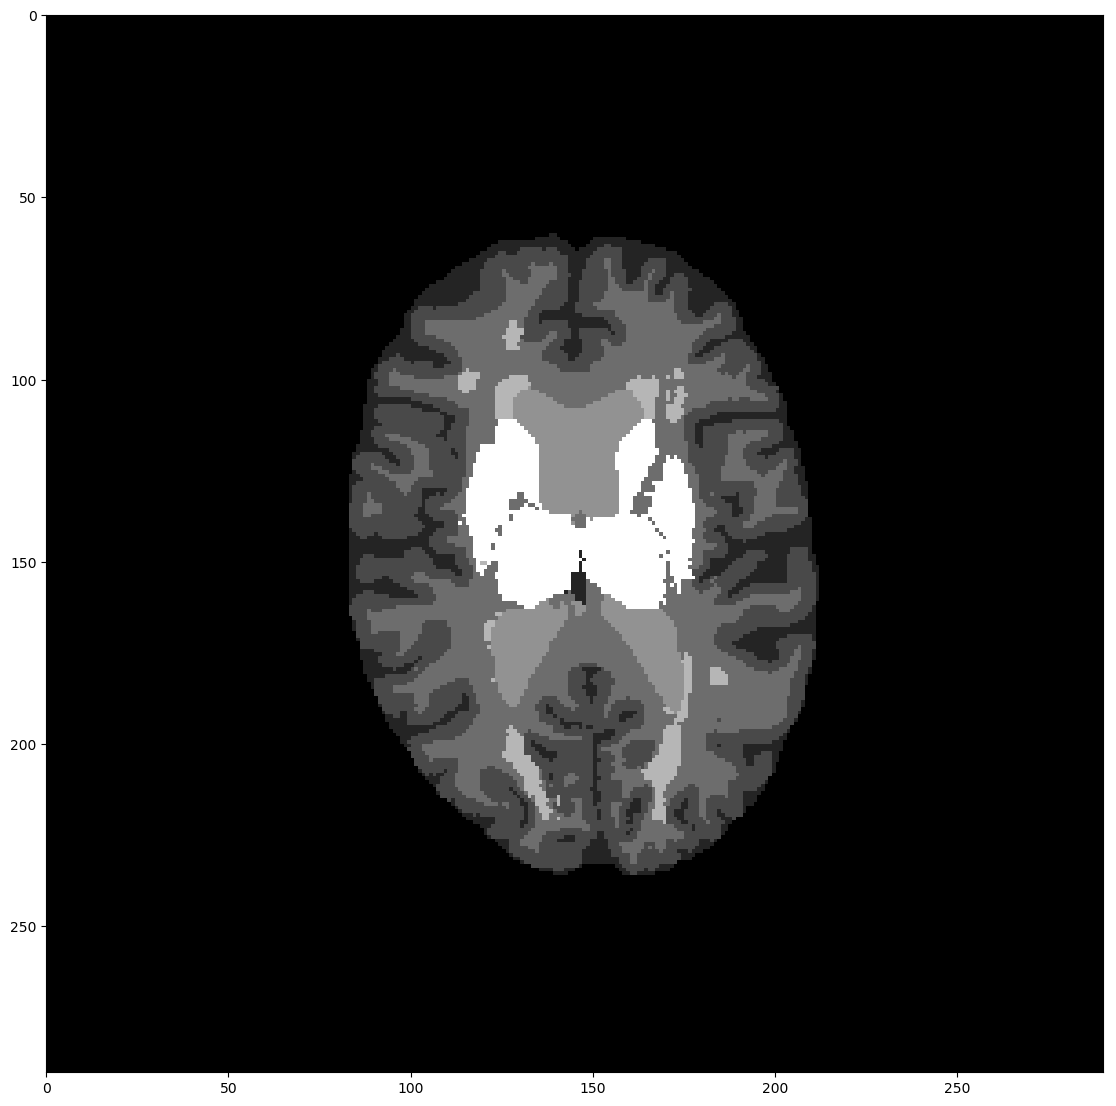

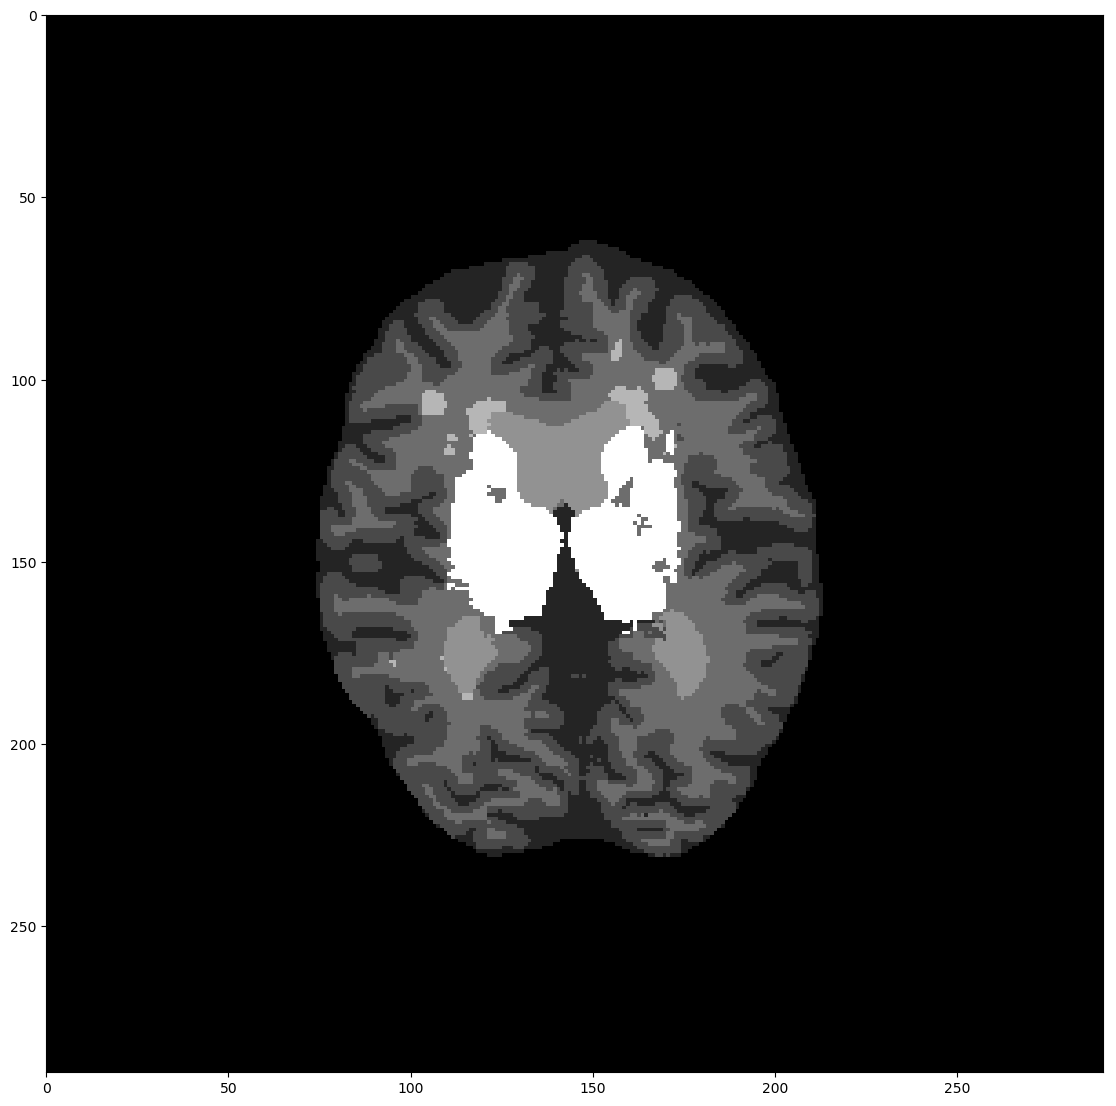

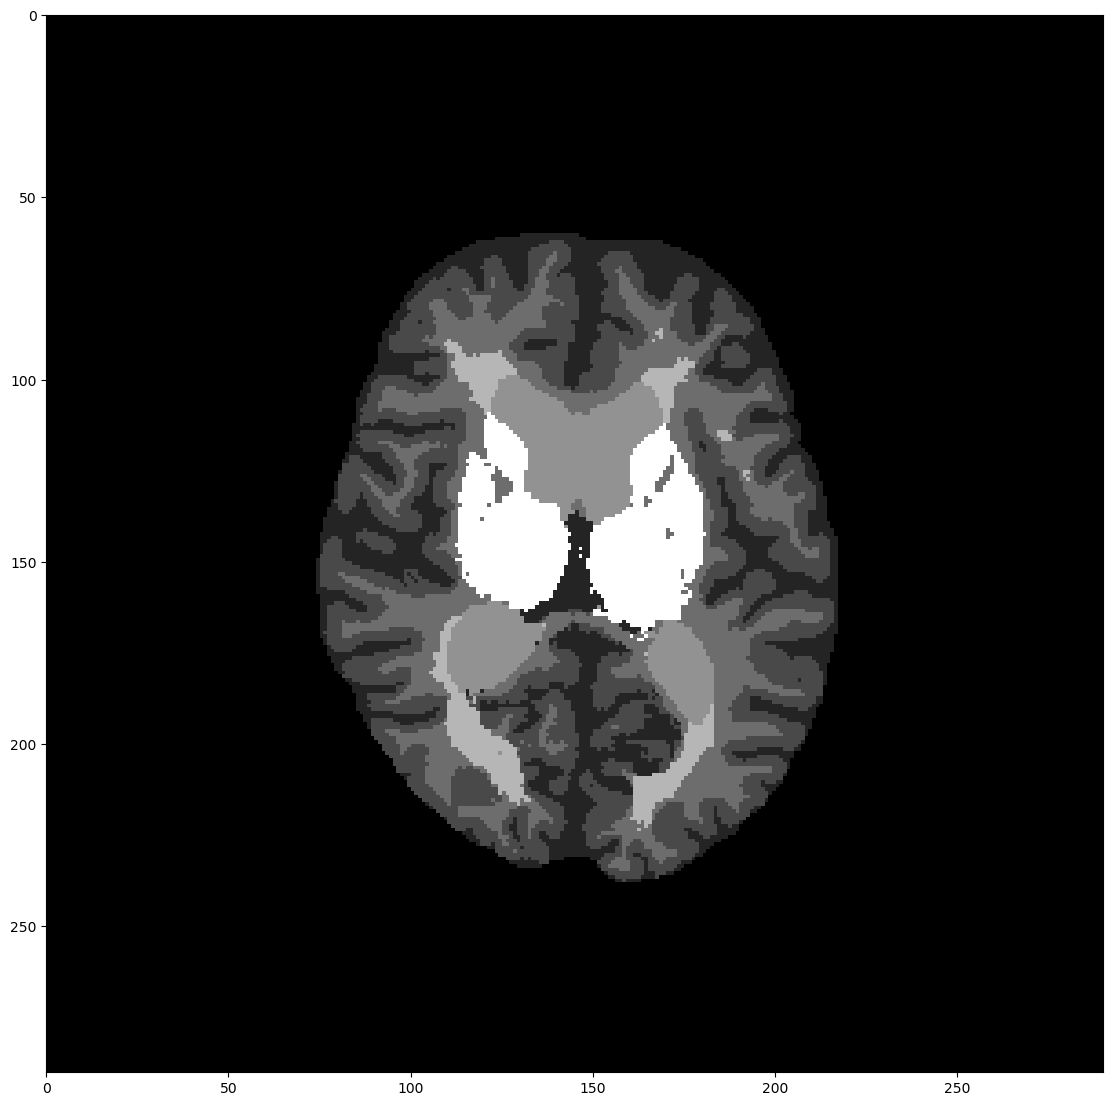

In [66]:
dst = np.zeros((5, 48, 290, 290, 1), dtype=np.int8)
dst[testMasks] = np.argmax(result, axis=1)
for k,i in enumerate(dst):
    a = sitk.GetImageFromArray(i[:,:,:,0])
    myshow(a)
    sitk.WriteImage(a,'C:/Users/Jing/Documents/umcu/src/model/balanced_3_'+str(k)+'.nii') 
    print(i[:,:,:,0].shape)

## Segmentation evaluation

In [23]:
from scipy.stats import itemfreq
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [24]:
testImages, testLabels, testMasks = loadData( "Z:/VoorJing/testing")
target = np.reshape(testLabels, (-1)).astype(int)

# with open("model_20181018_balanced.pickle", 'rb') as f:
#     result = pickle.load(f)
dst = np.zeros((5, 48, 290, 290, 1), dtype=np.int8)
dst[testMasks] = np.argmax(result, axis=1)

prediction = np.reshape(dst, (-1))
print("target:\n",itemfreq(target))
print("prediction:\n",itemfreq(prediction))

conf_mat = confusion_matrix(target,prediction)
print("\n", classification_report(target,prediction))


label_l= list(set(target).union(prediction))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=label_l, yticklabels=label_l)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: name 'result' is not defined

array([[8.71115853e-12, 9.96587038e-01, 3.35682044e-03, ...,
        1.20201496e-11, 9.23154522e-12, 1.36939167e-11],
       [6.88576366e-12, 9.96538162e-01, 3.42044351e-03, ...,
        9.82978282e-12, 7.00111236e-12, 1.04057735e-11],
       [3.47786860e-12, 9.97820497e-01, 2.15423666e-03, ...,
        4.61861018e-12, 3.08837548e-12, 5.23883454e-12],
       ...,
       [2.97169928e-12, 9.59135294e-01, 4.08227891e-02, ...,
        6.15418697e-12, 3.92090744e-12, 3.45216000e-12],
       [3.33483740e-12, 9.55839157e-01, 4.41122353e-02, ...,
        7.32136660e-12, 4.45740146e-12, 3.93996554e-12],
       [2.28732289e-12, 9.85405147e-01, 1.45710949e-02, ...,
        4.56758589e-12, 2.87287707e-12, 2.70323369e-12]], dtype=float32)

## Anomaly using IsolationForest

In [149]:
testPath = "Z:/VoorJing/extra-test"
   
testImages, testLabels, testMasks = loadData(testPath)
testNonZeroIdx = np.nonzero(testMasks)

model = keras.models.load_model("C:/Users/Jing/Documents/umcu/src/model/cnn_brain_segmentation_model_balenced_20181019_174700.h5")
novelty_model = Model(inputs=model.input, outputs=model.get_layer("dense_41").output)


iterator = batchTestGeneratorMasked(testImages, testLabels, testNonZeroIdx, batchShape)

i = 0
r = 0
result = None
novelty = None

for predictImages, predictLabels in iterator:
    resultModel = model.predict_on_batch(predictImages)
    resultNovelty = novelty_model.predict_on_batch(predictImages)
    
    if result is None:
        result = resultModel
        novelty = resultNovelty
    else:
        result = np.concatenate([result, resultModel])
        novelty = np.concatenate([novelty, resultNovelty])
        r+=1
        if r%2000==0:
            print (r)

2000
4000
6000
8000


In [157]:
testLabels.shape

(1, 48, 290, 290, 1)

In [150]:
result.shape

(586202, 14)

In [151]:
novelty.shape

(586202, 64)

In [152]:
pickle.dump( result,  open( 'model_20181022_balanced_100000_extra.pickle', 'wb' ) )
pickle.dump( novelty ,  open( 'novelty_20181022_balanced_100000_extra.pickle', 'wb' ) )


In [153]:
with open("model_20181022_balanced_100000.pickle", 'rb') as f:
    trainresult = pickle.load(f)
with open("novelty_20181022_balanced_100000.pickle", 'rb') as f:
    trainnovelty = pickle.load(f)

In [154]:
with open("model_20181022_balanced_100000_extra.pickle", 'rb') as f:
    result = pickle.load(f)
with open("novelty_20181022_balanced_100000_extra.pickle", 'rb') as f:
    novelty = pickle.load(f)

In [155]:
result.shape

(586202, 14)

In [156]:
trainresult.shape

(2371450, 14)

In [158]:
padding = 25
extra_testfile = "Z:/VoorJing/extra-test/D11/features/labels_truth.nii"
labelImage = sitk.ReadImage(extra_testfile)
labelArray = np.pad(sitk.GetArrayFromImage(labelImage), [(0,0),(padding,padding),(padding,padding)], 'constant')
ground_result = labelArray
ground_result.shape

(48, 290, 290)

In [31]:
from sklearn.ensemble import IsolationForest

In [35]:
rng = np.random.RandomState(42)
clf = IsolationForest(behaviour='new', contamination=0.1, 
                      n_estimators=100, max_samples='auto', 
                      max_features=1.0, bootstrap=False, n_jobs=-1, random_state=rng)
clf.fit(trainnovelty)
y_pred_train = clf.predict(trainnovelty)
y_pred_outliers = clf.predict(novelty)

In [36]:
itemfreq(y_pred_outliers)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[    -1,  48534],
       [     1, 537668]], dtype=int64)

In [37]:
itemfreq(y_pred_train)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[     -1,  237145],
       [      1, 2134305]], dtype=int64)

In [136]:
y_pred_outliers.shape

(586202,)

(48, 290, 290)


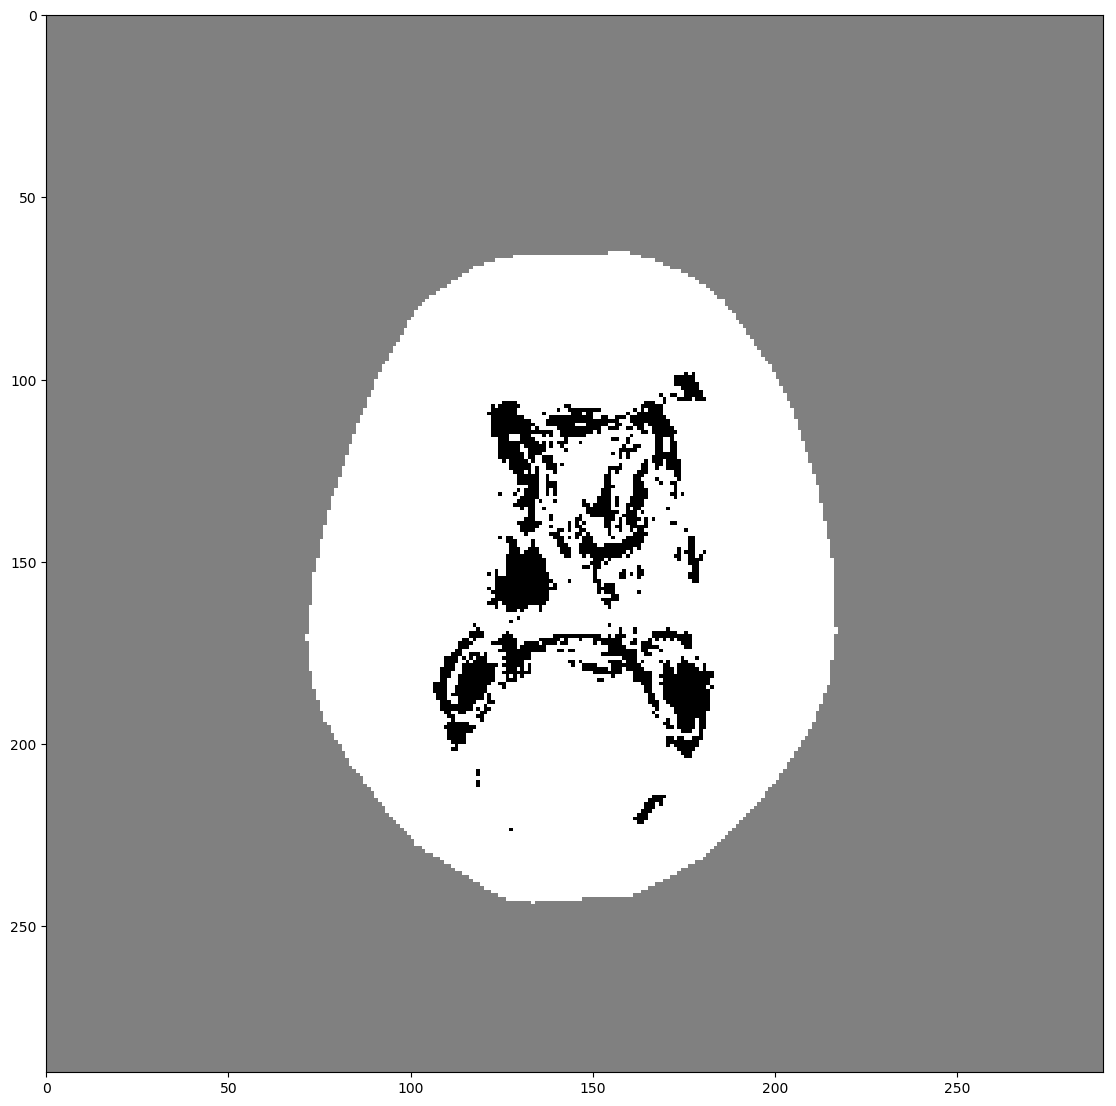

In [137]:
dst = np.zeros((1, 48, 290, 290, 1), dtype=np.int8)
dst[testMasks] = y_pred_outliers
for k,i in enumerate(dst):
    a = sitk.GetImageFromArray(i[:,:,:,0])
    myshow(a)
#     sitk.WriteImage(a,'C:/Users/Jing/Documents/umcu/src/model/balanced_3_'+str(k)+'.nii') 
    print(i[:,:,:,0].shape)

In [139]:
dst.shape

(1, 48, 290, 290, 1)

In [98]:
testLabels.shape

(1, 48, 290, 290, 1)

In [161]:
target.shape

(48, 290, 290)

In [162]:
prediction.shape

(4036800,)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


target:
 [[0.00000e+00 4.03487e+06]
 [1.00000e+00 1.93000e+03]]
prediction:
 [[      0 3988266]
 [      1   48534]]


C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.



               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   4034870
         1.0       0.02      0.48      0.04      1930

   micro avg       0.99      0.99      0.99   4036800
   macro avg       0.51      0.74      0.52   4036800
weighted avg       1.00      0.99      0.99   4036800



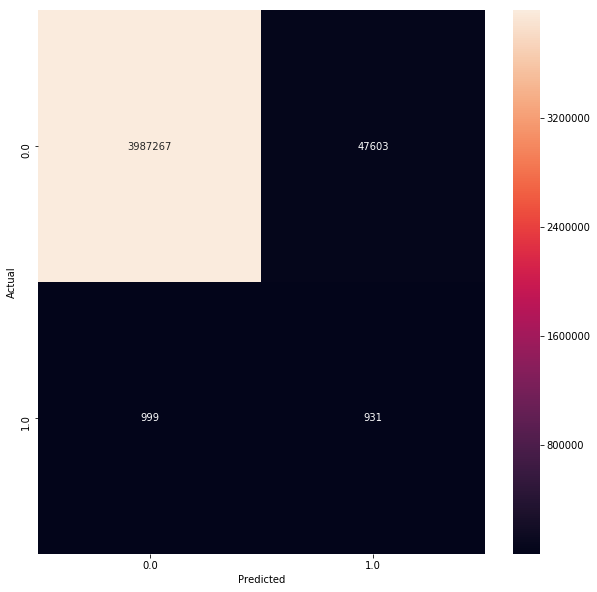

In [163]:
target = ground_result.flatten()
prediction = np.reshape(dst, (-1))==-1
print("target:\n",itemfreq(target))
print("prediction:\n",itemfreq(prediction))

conf_mat = confusion_matrix(target,prediction)
print("\n", classification_report(target,prediction))


label_l= list(set(target).union(prediction))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=label_l, yticklabels=label_l)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## KNN

In [49]:


import data

import scipy.ndimage.measurements
import time

import cyflann


In [70]:
result.shape

(586202, 14)

In [81]:
testResult  = np.argmax(result, axis=1)

In [71]:
novelty.shape

(586202, 64)

In [72]:
trainresult.shape

(2371450, 14)

In [73]:
trainnovelty.shape

(2371450, 64)

In [74]:
s = np.random.randint(0, len(novelty), 50000)
idx = cyflann.FLANNIndex(algorithm='linear')
idx.build_index(novelty[s]) 

In [75]:
feature_avg = np.mean(trainnovelty, axis=1)
feature_std = np.std(trainnovelty, axis=1)

In [76]:
feature_std.shape

(2371450,)

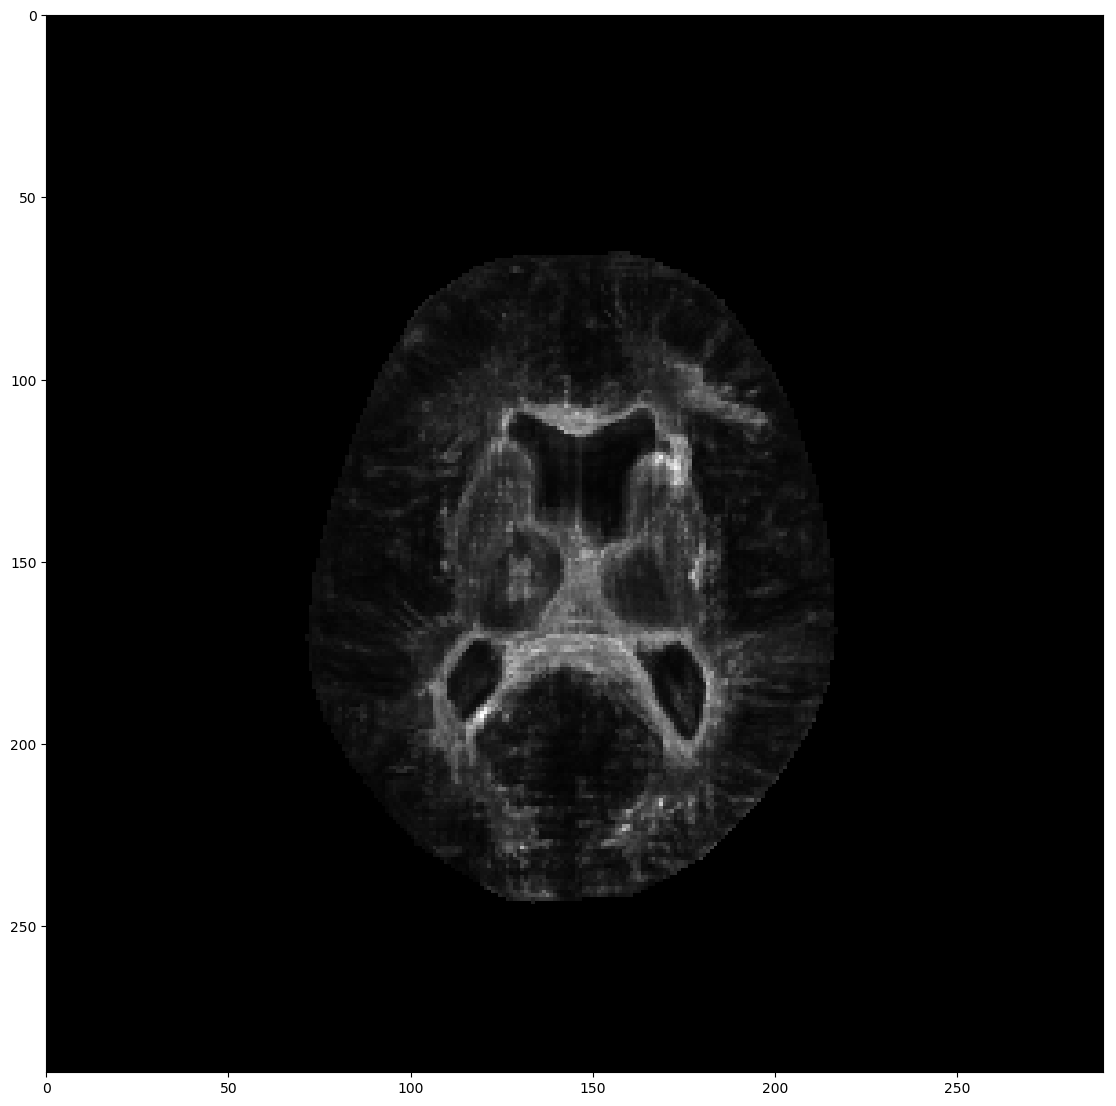

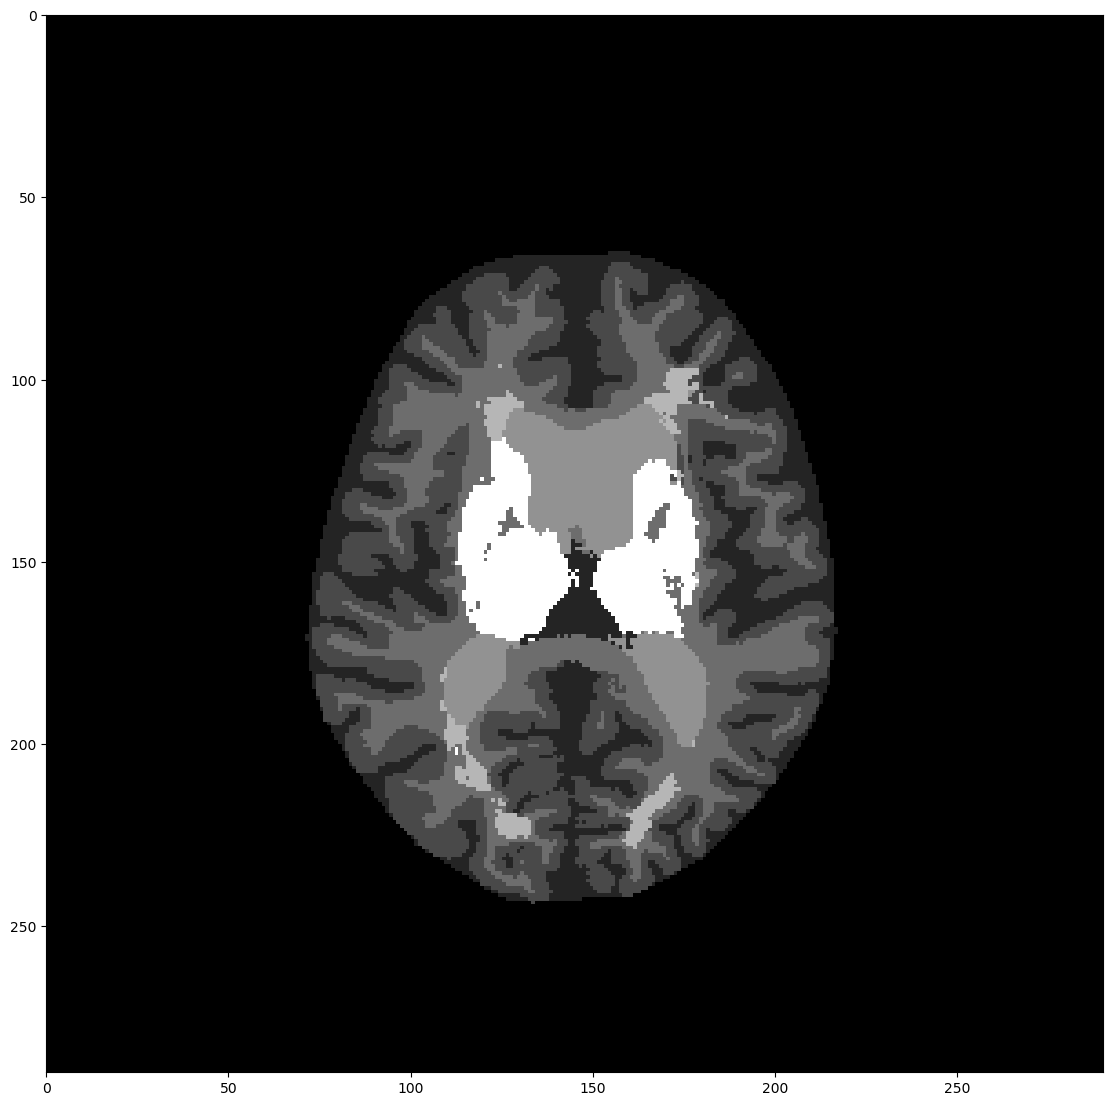

In [87]:
#%% Run the subject through the NN
test_ind, test_dist = idx.nn_index(novelty, 51)
test_dist_feature = np.mean(test_dist, axis=1)
zscore = (test_dist_feature - feature_avg[testResult]) / feature_std[testResult]

zdst = np.zeros(testMasks.shape)
zdst[testMasks] = zscore

zImage = sitk.GetImageFromArray(zdst[0,:,:,:,0])
myshow(zImage)
# sitk.WriteImage(zImage, "C:/Users/Jing/Documents/umcu/src/model/zscore_20181023.nii")

rdst = np.zeros(testMasks.shape)
rdst[testMasks] = testResult
zImage = sitk.GetImageFromArray(rdst[0,:,:,:,0])
myshow(zImage)
# sitk.WriteImage(zImage, "C:/Users/Jing/Documents/umcu/src/model/zsegm_20181023.nii")

In [88]:
zdst.shape

(1, 48, 290, 290, 1)

In [98]:
zdst.shape

(1, 48, 290, 290, 1)

In [89]:
itemfreq(zdst)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[0.00000000e+00, 3.45059800e+06],
       [2.64742553e-01, 1.00000000e+00],
       [2.82944351e-01, 1.00000000e+00],
       ...,
       [6.35631065e+01, 1.00000000e+00],
       [6.63694992e+01, 1.00000000e+00],
       [6.88536987e+01, 1.00000000e+00]])

In [164]:
z4dst = zdst > 4

In [165]:
z4dst= z4dst.astype(int)

In [166]:
z4dst.shape

(1, 48, 290, 290, 1)

In [167]:
itemfreq(z4dst)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[      0, 3699159],
       [      1,  337641]], dtype=int64)

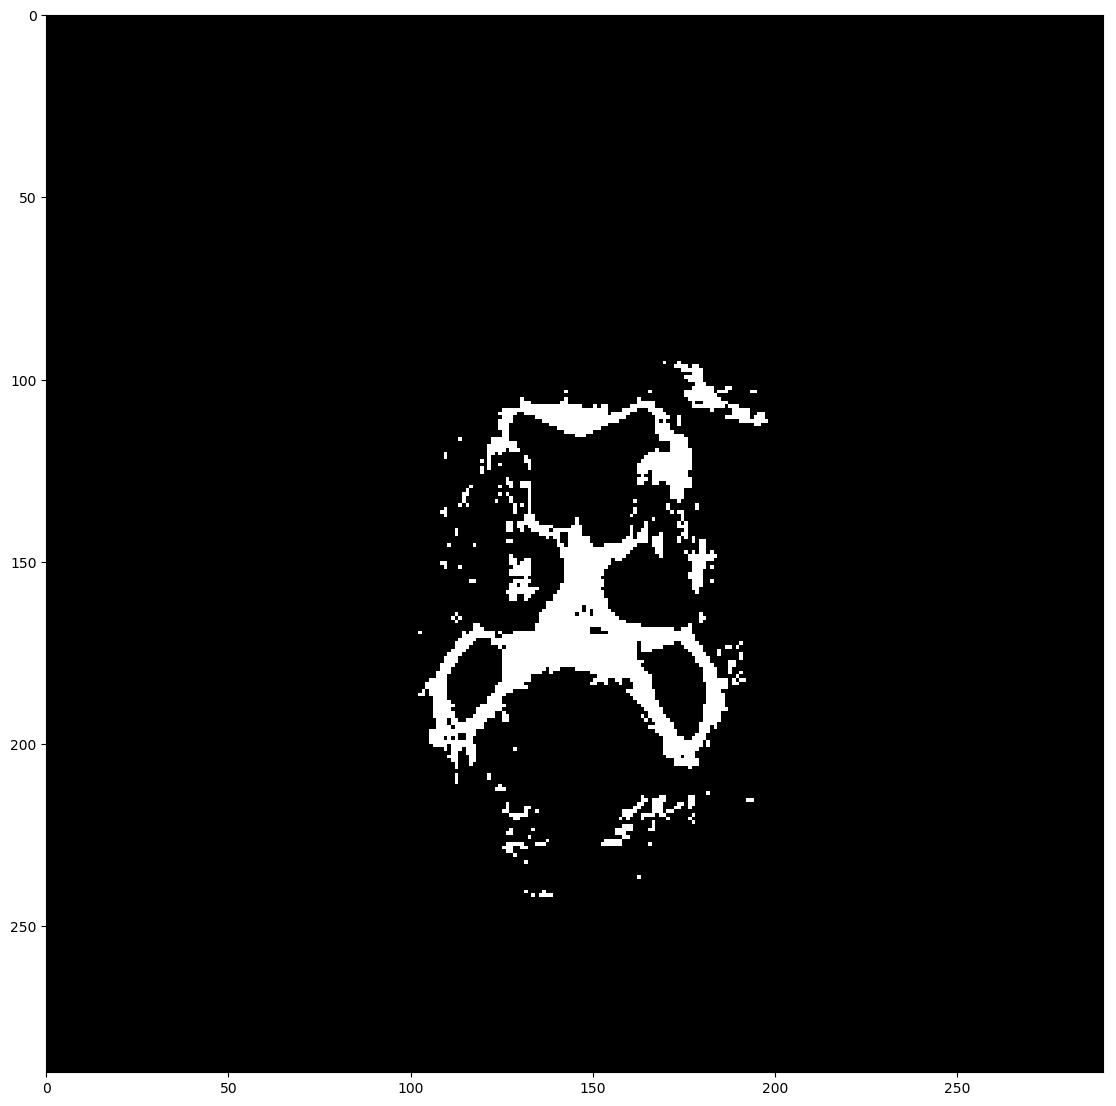

In [133]:
zImage = sitk.GetImageFromArray(z4dst[0,:,:,:,0])
myshow(zImage)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  This is separate from the ipykernel package so we can avoid doing imports until


target:
 [[0.00000e+00 4.03487e+06]
 [1.00000e+00 1.93000e+03]]
prediction:
 [[      0 3699159]
 [      1  337641]]


C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.



               precision    recall  f1-score   support

         0.0       1.00      0.92      0.96   4034870
         1.0       0.01      0.98      0.01      1930

   micro avg       0.92      0.92      0.92   4036800
   macro avg       0.50      0.95      0.48   4036800
weighted avg       1.00      0.92      0.96   4036800



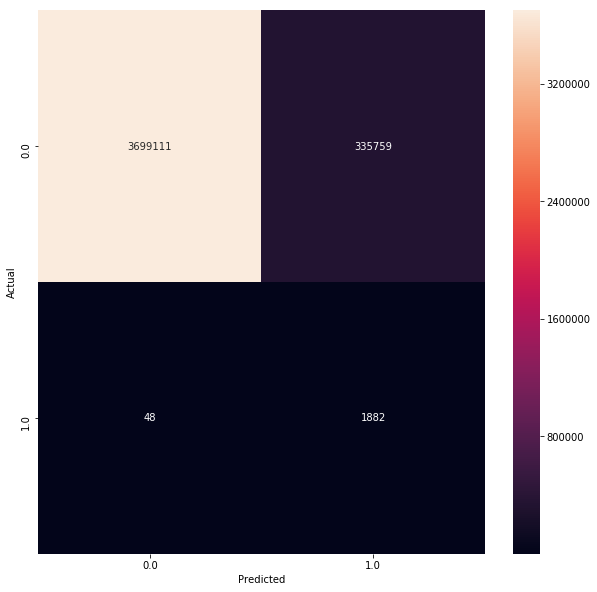

In [168]:
target = ground_result.flatten()
prediction = np.reshape(z4dst, (-1))
print("target:\n",itemfreq(target))
print("prediction:\n",itemfreq(prediction))

conf_mat = confusion_matrix(target,prediction)
print("\n", classification_report(target,prediction))


label_l= list(set(target).union(prediction))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=label_l, yticklabels=label_l)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## ground truth for novalty

In [78]:
target =sitk.GetArrayFromImage(sitk.ReadImage("C:/Users/Jing/Documents/umcu/T2_FLAIR.infarct.nii"))

In [80]:
target.shape

(48, 240, 240)

In [86]:
itemfreq(target)

C:\Users\Jing\Anaconda3\envs\jing\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  """Entry point for launching an IPython kernel.


array([[0.00000e+00, 2.76287e+06],
       [1.00000e+00, 1.93000e+03]])

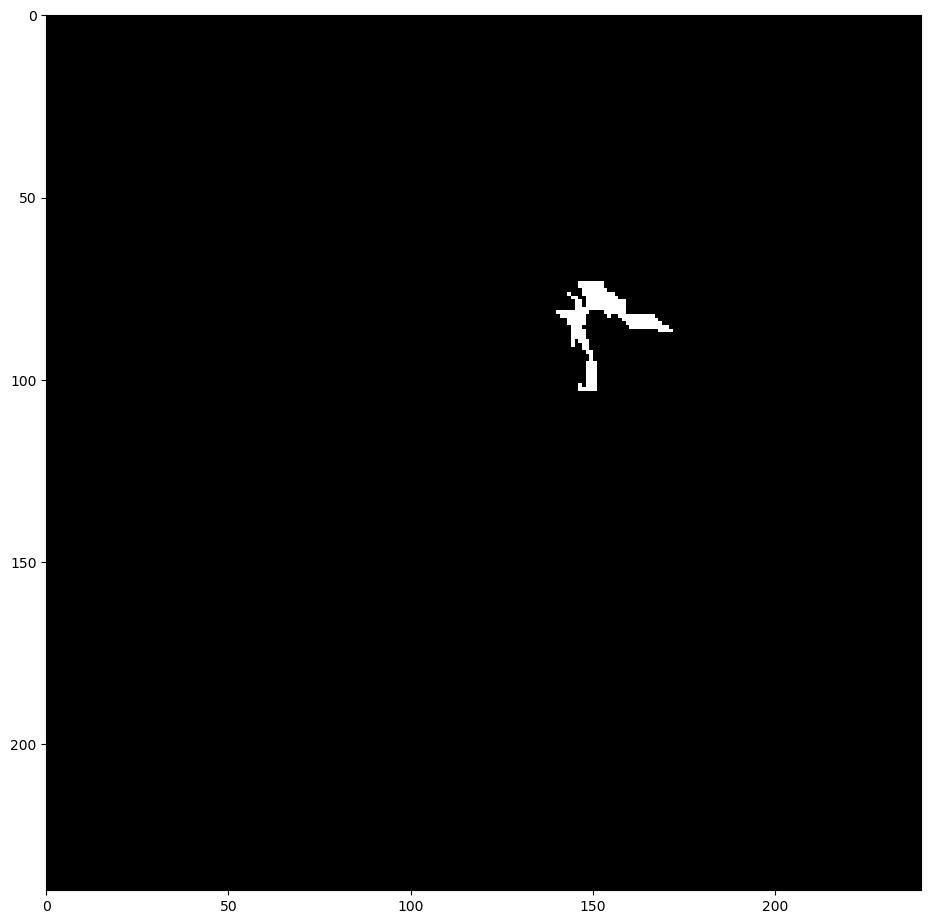

In [85]:
a = sitk.GetImageFromArray(target)
myshow(a)